In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, math
from tqdm.notebook import tqdm
import copy

import csv
import re

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from einops import rearrange, reduce, repeat

In [3]:
import parser
import transformer
import longrange
import dataset
import train
import util

10745856

In [20]:
x = torch.randint(0, 128, (1, 256))
logits, memory_out = net.forward(x)
logits.shape#, memory_out.shape

torch.Size([1, 256, 128])

In [9]:
ids_book = parser.book2ids()

In [10]:
ds_train, ds_test = dataset.load_dataset(tqdm=tqdm)

Found existing dataset at ../data/datasets.pkl


In [142]:
def graph_it(net, ds=ds_train, n_batches=10, device='cpu'):
    net.to(device)
    net.eval()
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    batch_size, seq_len = 32, 256
    
    losses = []
    
    for batch in tqdm(dataset.get_random_batches(ds, n_batches, batch_size=batch_size, seq_len=seq_len), total=n_batches):
        batch = batch.to(device).long()
        inputs, targets = batch[:, :-1], batch[:, 1:]
        logits, _ = net.forward(inputs)
        
        # targets = targets[:, -logits.size(1) :]
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), targets.reshape(-1)).reshape(batch_size, seq_len-1)
        
        losses.append(loss.detach().mean(dim=0).cpu())
    losses = torch.stack(losses).mean(dim=0).detach().cpu().numpy()
    
    plt.figure(figsize=(20, 5))
    plt.subplot(121); plt.plot(losses);# plt.ylim(0, 5.3)
    plt.subplot(122); plt.plot(np.exp(losses));# plt.ylim(0, np.exp(5.3))
    plt.show()
    return losses


In [117]:
net = longrange.LongRangeGPT(**longrange.get_config("transformer"))
util.count_params(net)

10745856

  0%|          | 0/200 [00:00<?, ?it/s]

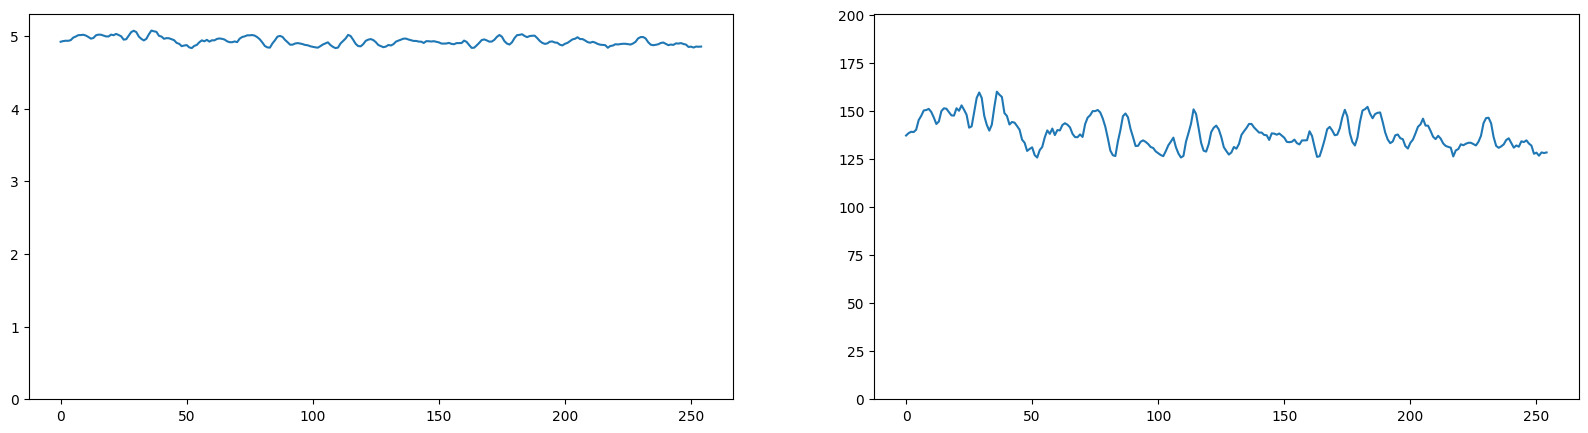

In [118]:
graph_it(net, n_batches=200, device='cuda:1')

In [119]:
train.train_transformer(ds_train, net, n_batches=2000, batch_size=32, seq_len=256, lr=1e-3, device='cuda:1', tqdm=tqdm)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

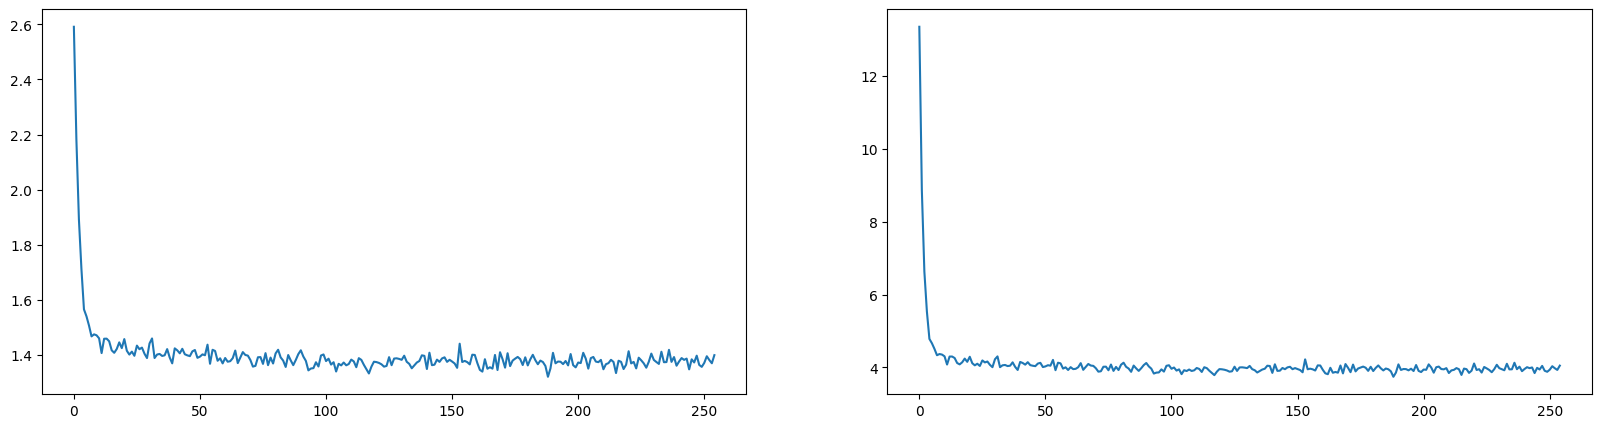

In [128]:
graph_it(net, n_batches=200, device='cuda:1')

In [137]:
ids = parser.text2ids('And then the king said ')[None].to('cuda:1').long()
net.eval()
ids = longrange.generate_ak(net, ids, n_tokens=1000, max_context_length=256, do_sample=True)[0]

In [138]:
parser.ids2text(ids)

'And then the king said of\nlate. I reply when I would have had to you."\n\n"\'You be in that order now, I hadn\'t shall over it away at me.\nShe caught it dome put out on a fightly country.\n\nBazzeth\'s appared with a; he said: "Well, then. I had say if you that\ncountry excuted as first a foreign: and as it aslight she did is\nwolding you?"\n\nhe punished.\n\n\n"Truntly you say for that."\n\n"Colloset she would nyielder than breautter have turn her equally before\nKenty Wats," thought, brandled.\n\n\nIt but she ome will have beeen return his word of somebody, as a shower\nwearing to the roof suddden in Krench. The one whoever was so quite\ngradually. "Come it hope bee to express he will play just having to also\nfutture to recile it. Well-par\'---thought here, and did you say?"\nreported. "It\'s all," I contemported, shaking at haffird---it gravely.\nHe would do like a livifly?"\n\n"The truth fighter. Let us the hollers I came a hours to help wyour\nparty of this transplem to Liprim

In [139]:
print(parser.ids2text(ids))

And then the king said of
late. I reply when I would have had to you."

"'You be in that order now, I hadn't shall over it away at me.
She caught it dome put out on a fightly country.

Bazzeth's appared with a; he said: "Well, then. I had say if you that
country excuted as first a foreign: and as it aslight she did is
wolding you?"

he punished.


"Truntly you say for that."

"Colloset she would nyielder than breautter have turn her equally before
Kenty Wats," thought, brandled.


It but she ome will have beeen return his word of somebody, as a shower
wearing to the roof suddden in Krench. The one whoever was so quite
gradually. "Come it hope bee to express he will play just having to also
futture to recile it. Well-par'---thought here, and did you say?"
reported. "It's all," I contemported, shaking at haffird---it gravely.
He would do like a livifly?"

"The truth fighter. Let us the hollers I came a hours to help wyour
party of this transplem to Liprimate Brackey's, whosever send to t

  0%|          | 0/200 [00:00<?, ?it/s]

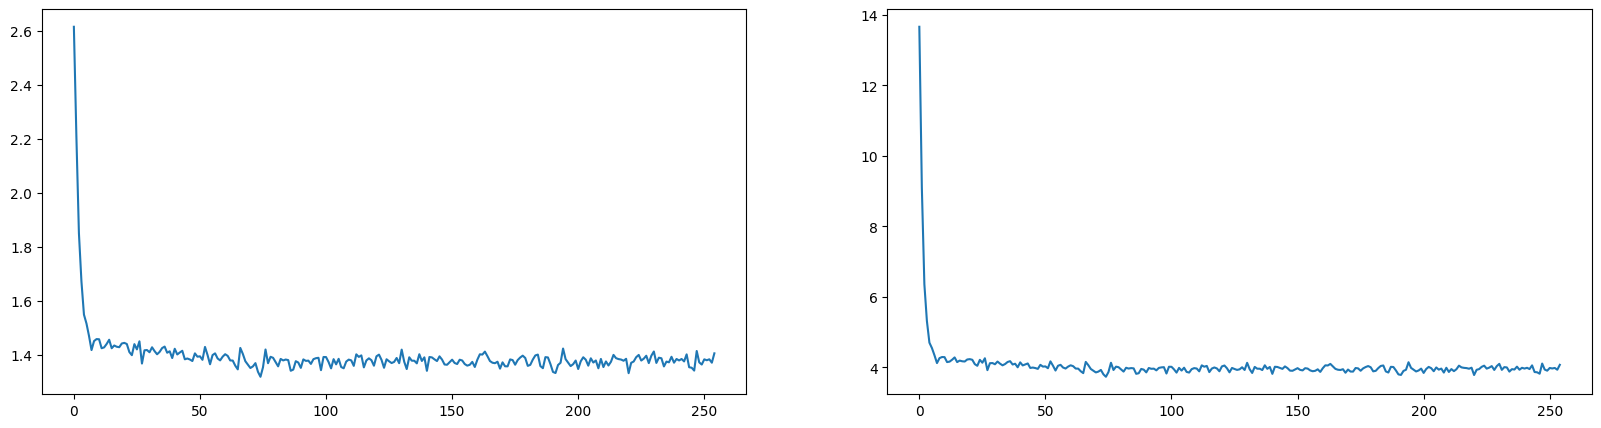

In [140]:
graph_it(net, ds=ds_train, n_batches=200, device='cuda:1')

  0%|          | 0/200 [00:00<?, ?it/s]

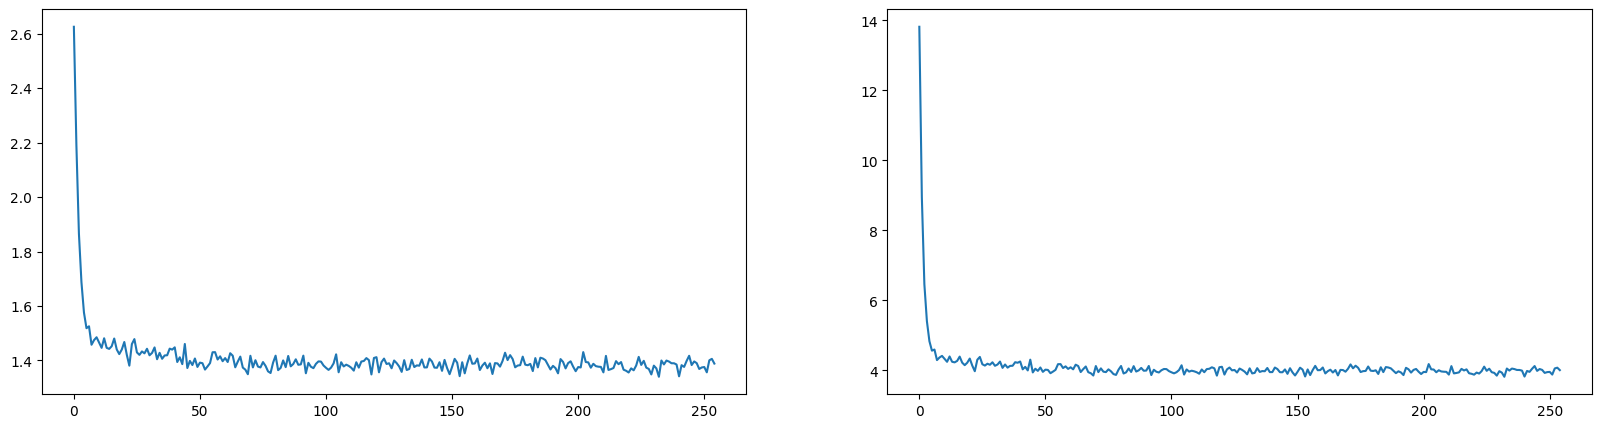

In [141]:
graph_it(net, ds=ds_test, n_batches=200, device='cuda:1')

  0%|          | 0/200 [00:00<?, ?it/s]

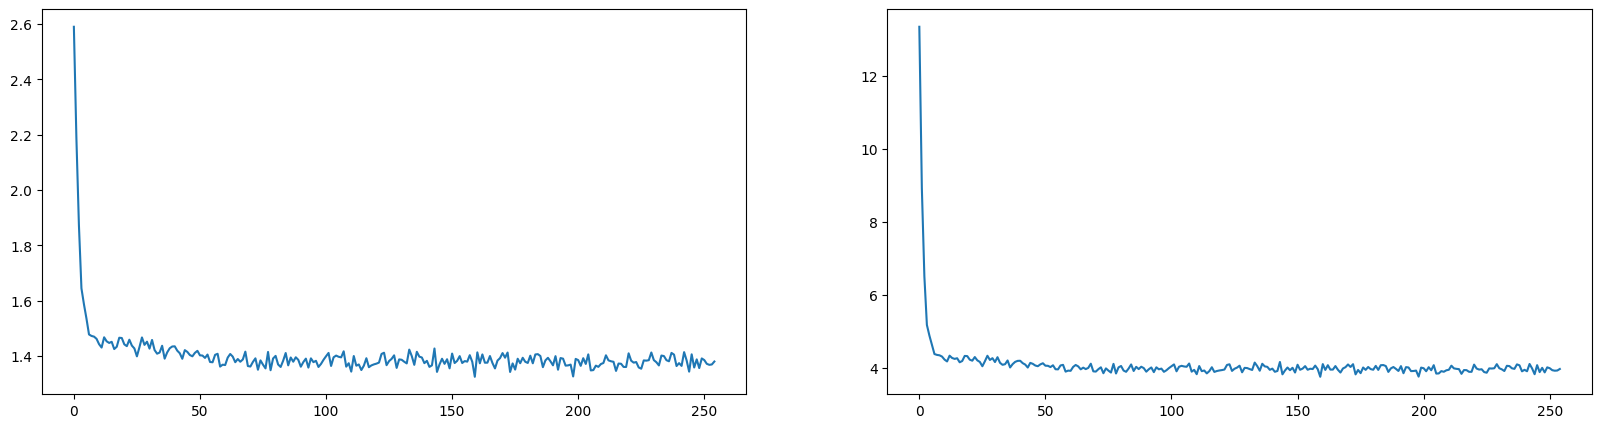

In [143]:
losses = graph_it(net, ds=ds_test, n_batches=200, device='cuda:1')

(0.0, 20.0)

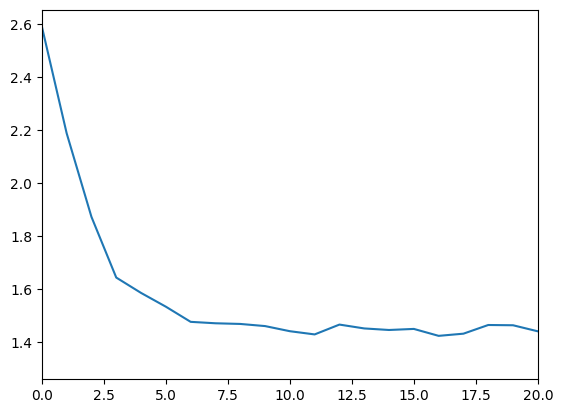

In [148]:
plt.plot(losses)
plt.xlim(0, 20)
# plt.xscale('log')

In [49]:
batch1, batch2 = next(dataset.get_random_skip_batches(a, 1, 128, 256))

In [52]:
longrange.loss_fn_longrange(net, batch1.long(), batch2.long())

tensor(4.9990, grad_fn=<DivBackward0>)

In [91]:
block = transformer.Block(dict(n_embd=384, n_head=1, attn_pdrop=.1, resid_pdrop=.1))

In [92]:
x = torch.randn(1, 10, 384)
y = torch.randn(1, 20, 384)
nx, ny = x.shape[-2], y.shape[-2]
mask = ~torch.tril(torch.ones(nx, ny, device=x.device), diagonal=ny-nx).to(bool)
a, b = block.attn(x, y, y, attn_mask=mask)
a.shape, b.shape

(torch.Size([1, 10, 384]), torch.Size([1, 10, 20]))

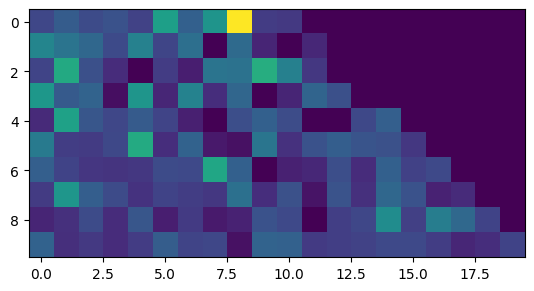

In [93]:
plt.imshow(b[0].detach().numpy())